<a href="https://colab.research.google.com/github/yuri98s/Analise-Exploratoria-de-Dados-de-Logistica/blob/main/projeto_loggi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# **Módulo** | Análise de Dados: Análise Exploratória de Dados de Logística II

---

# **Tópicos**

<ol type="1">
  <li>Manipulação;</li>
  <li>Visualização;</li>
  <li>Storytelling.</li>
</ol>


---

# **Análise Exploratória de Dados de Logística**

## 1\. Contexto

O arquivo usado neste noteboook contém dados da Empresa de Logística Loggi, nele há dados dos centros de distribuições (Hubs) e também das coordenadas de entrega (Delivery).
O propósito deste projeto é entender como está sendo feita a distribuição dos itens do 'delivery' e tentar otimizar este processo.

O conteúdo do material pode ser acessado através deste [link](https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json).

## 2\. Pacotes e bibliotecas

In [ ]:
# - 1º pacotes nativos do python____________________________________________________________________________________________________________

!pip install geopandas

import json
import numpy as np
from numpy import float64

# - 2º pacotes de terceiros__________________________________________________________________________________________________________________

import pandas as pd
import seaborn as sns
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import geopandas
import matplotlib
import matplotlib.pyplot as plt

## 3\. Exploração de dados

Coleta de dados

In [78]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json" -O deliveries.json
with open(file='deliveries.json',mode='r',encoding='utf8') as fp:
  dado = json.load(fp)

* **Wrangling da estrutura**

Transformando o formato dos dados da coluna 'origin' de nested para flatten com o método 'pd.json_normalize' em um novo Dataframe.

In [79]:
dado_df = pd.DataFrame(dado)
origin = pd.json_normalize(dado_df['origin'])

Fazendo a junção do dataframe 'origin' ao Dataframe principal utilizando 'pd.merge'.

In [80]:
dado_df = pd.merge(left= dado_df,right= origin, how= 'inner', left_index= True, right_index= True)
dado_df = dado_df.drop('origin', axis= 1).rename(columns = {'lng':'hub_lng','lat':'hub_lat'})
dado_df = dado_df[['name',	'region',	'hub_lng',	'hub_lat', 'vehicle_capacity',	'deliveries']]

Transformando o formato dos dados da coluna 'deliveries' de nested para flatten com o método '.explode' em um novo Dataframe e usando a normalização para a preservar os índices.

In [81]:
delivery = dado_df[['deliveries']].explode('deliveries')
deliveries_exploded = pd.concat([
    pd.DataFrame(delivery['deliveries'].apply(lambda i: i['size'])).rename(columns={'deliveries':'delivery_size'}),
    pd.DataFrame(delivery['deliveries'].apply(lambda i: i['point']['lng'])).rename(columns={'deliveries':'delivery_lng'}),
    pd.DataFrame(delivery['deliveries'].apply(lambda i: i['point']['lat'])).rename(columns={'deliveries':'delivery_lat'}),
], axis= 1)

Fazendo a junção do dataframe de 'delivery' no Dataframe principal baseado nos índices usando 'pd.merge'.

In [82]:
dado_df = dado_df.drop('deliveries', axis= 1)
dado_df = pd.merge(left= dado_df, right= deliveries_exploded, how='right', left_index= True, right_index= True )
dado_df.reset_index(inplace= True, drop= True)

## 4\. Manipulação

* **Enriquecimento**

Geocodificação reversa dos Hubs

In [83]:
hub_df = dado_df[['region','hub_lng','hub_lat']]
hub_df = hub_df.drop_duplicates().sort_values(by='region').reset_index(drop= True).dropna()

Aplicando o 'Ratelimiter' com a geolocalização reversa e o tempo de delay como parâmetros.

In [84]:
geolocator = Nominatim(user_agent='ebac_geocoder')
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds= 1)

Criando uma nova coluna que é a combinação de longitute e latitude dos hubs, aplicando a geolocalização reversa.

In [85]:
hub_df['cordenadas'] = hub_df['hub_lat'].astype(str)+', '+hub_df['hub_lng'].astype(str)
hub_df['geodata'] = hub_df['cordenadas'].apply(geocoder)

Criando um novo Dataframe normalizando a coluna 'geodata' com 'pd.json_normalize'.

In [86]:
hub_geodata_df = pd.json_normalize(hub_df['geodata'].apply(lambda data: data.raw))

Aplicando tratamentos no Dataframe 'hub_geodata_df' usando a bibliotéca Numpy 'np.where' para evitar a falta de dados nas colunas 'hub.city' e 'hub_suburb'.

In [87]:
hub_geodata_df = hub_geodata_df[['address.city','address.suburb','address.town']].rename(columns= {'address.town':'hub_town','address.suburb':'hub_suburb','address.city':'hub_city'})
hub_geodata_df['hub_city'] = np.where(hub_geodata_df['hub_city'].notna(), hub_geodata_df['hub_city'], hub_geodata_df['hub_town'])
hub_geodata_df['hub_suburb'] = np.where(hub_geodata_df['hub_suburb'].notna(), hub_geodata_df['hub_suburb'],hub_geodata_df['hub_city'])
hub_geodata_df = hub_geodata_df.drop('hub_town',axis= 1)

Junção dos Dataframes 'hub_geodata_df' com o 'hub_df' mantendo o index para ter como resultado as regiões e informações de bairro e de cidade dos Hubs.

In [88]:
hub_df = pd.merge(left= hub_df, right= hub_geodata_df, left_index= True, right_index= True)
hub_df = hub_df[['region', 'hub_suburb','hub_city']]

Juntando o Dataframe 'hub_df' ao Dataframe principal com parâmetro 'on= "region" ' para preservar a ordem e levar as informações de bairro e cidade.

In [89]:
dado_df = pd.merge(left= dado_df, right= hub_df, how= 'inner', on= 'region')
dado_df = dado_df[['name',	'region',	'hub_lng',	'hub_lat', 'hub_city', 'hub_suburb', 'vehicle_capacity',	'delivery_size', 'delivery_lng', 'delivery_lat']]

Geocodificação reversa dos deliveries



> Devido o fato do servidor do Nominatim conter um tempo de Delay de 1 segundo no mínimo por consulta, as entregas, por terem 636.149 geolocalizações, levaria aproximadamente 7 dias para execução de todos os dados, então, o professor do curso disponibilizou estes dados que ele processou em seu próprio computador.
Os dados se encontram neste [link](https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv).



In [90]:
!wget -q 'https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv' -O deliveries-geodata.csv
delivery_geodata_df = pd.read_csv('deliveries-geodata.csv')

Junção do Dataframe que contém os dados de entrega e o Dataframe principal.

In [91]:
dado_df = pd.merge(left= dado_df, right= delivery_geodata_df[['delivery_city', 'delivery_suburb']], how= 'inner', left_index= True, right_index= True)

## 5\. Visualização

Vamos fazer o download do shapefile do Distrito Federal no site do [IBGE](https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip) para criar um Dataframe 'mapa' usando Geopandas.

In [ ]:
!wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip
!unzip -q distrito-federal.zip -d ./maps
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx

mapa = geopandas.read_file("distrito-federal.shp")
mapa = mapa.loc[[0]]
mapa.head()

replace ./maps/ASB_Cemiterio_A.dbf? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Hubs

Vamos criar o GeoDataFrame geo_hub_df através do DataFrame dado_df.

In [93]:
hub_df = dado_df[['region','hub_lng','hub_lat']].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry= geopandas.points_from_xy(hub_df['hub_lng'], hub_df['hub_lat']))

Deliveries

Vamos criar o GeoDataFrame geo_deliveries_df através do DataFrame dado_df.

In [94]:
geo_deliveries_df = geopandas.GeoDataFrame(dado_df, geometry=geopandas.points_from_xy(dado_df['delivery_lng'], dado_df['delivery_lat']))

* **Visualização**

Para visualização gráfica usaremos a Bibliotéca matplotlib e o shapefile contido em 'mapa'.

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


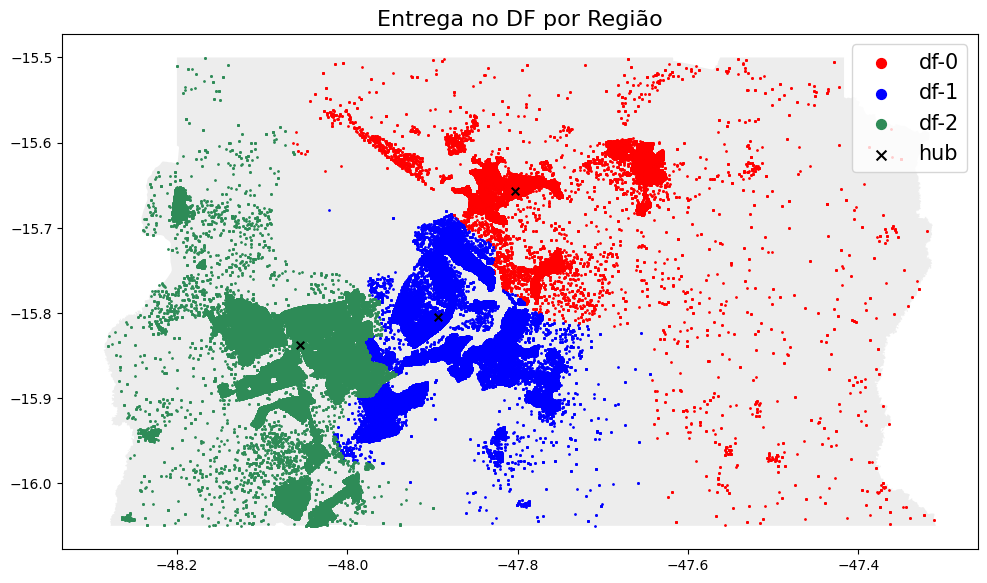

In [95]:
# plot vazio
fig, ax = plt.subplots(figsize= (30/2.54, 30/2.54))

# plot mapa do DF
mapa.plot(ax= ax, alpha= 0.4, color= "lightgrey")

# plot Deliveries
geo_deliveries_df.query("region == 'df-0'").plot(ax= ax, markersize= 1, color= 'red', label= 'df-0')
geo_deliveries_df.query("region == 'df-1'").plot(ax= ax, markersize= 1, color= 'blue', label= 'df-1')
geo_deliveries_df.query("region == 'df-2'").plot(ax= ax, markersize= 1, color= 'seagreen', label= 'df-2')

# plot Hubs
geo_hub_df.plot(ax= ax, markersize= 30, marker= "x", color= "black", label= "hub")

# plot legenda
plt.title("Entrega no DF por Região", fontdict ={"fontsize":16})
lgnd = plt.legend(prop={"size": 15})
for handle in lgnd.legend_handles:
    handle.set_sizes([50])

Visualização em um gráfico de pizza.

aproximadamente 90% das entregas são realizadas nas regiões 'df-1' e 'df-2' devido à densidade populacional presentes nestas regiões, porém,
a capacidade veicular é a mesma para todos os hubs mesmo a 'df-0' atendendo apenas 10% do total de entregas,
sugiro que os veiculos da região 'df-0' sejam deslocados às regiões de maior tráfego.


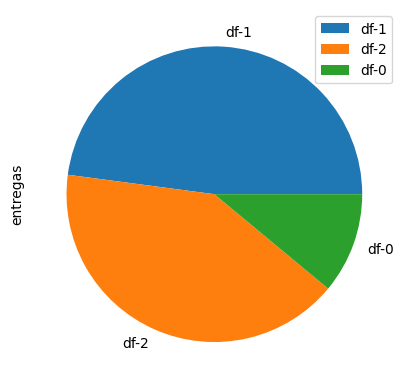

In [96]:
visualizacao = dado_df[['region','vehicle_capacity']].value_counts(normalize= True).reset_index().rename(columns={0:'percent'}).drop('vehicle_capacity', axis=1)
visualizacao.head()

grafico = visualizacao.plot.pie(y= "percent", labels= visualizacao["region"] )
grafico.set(ylabel= 'entregas')

# insights encontrados_____________________________________________________________________________________________________________________________________________
print("aproximadamente 90% das entregas são realizadas nas regiões 'df-1' e 'df-2' devido à densidade populacional presentes nestas regiões, porém,"+"\n"+"a capacidade veicular é a mesma para todos os hubs mesmo a 'df-0' atendendo apenas 10% do total de entregas,"+"\n"+"sugiro que os veiculos da região 'df-0' sejam deslocados às regiões de maior tráfego.")